In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

In [2]:
os.chdir('../')

### Train RF on banana dataset

In [3]:
df = pd.read_csv('./data/banana.csv')
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

clf = RandomForestClassifier(n_estimators=3, random_state=7)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.88


### Visualize decision boundaries

##### Boundaries of each tree

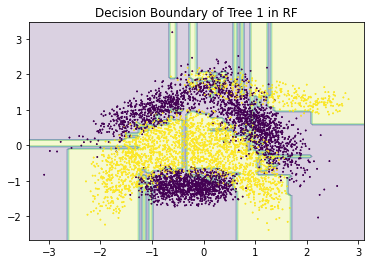

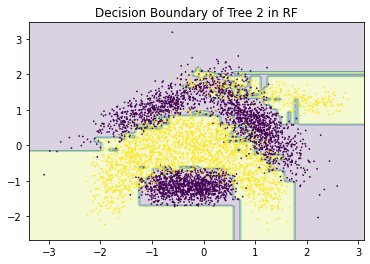

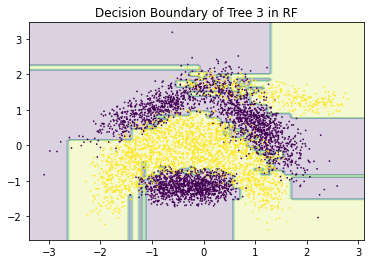

<Figure size 432x288 with 0 Axes>

In [4]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)

# Create a grid of points over the plot
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Apply the decision function of each tree to the grid of points
tree_preds = []
for i,tree in enumerate(clf.estimators_):
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)
    plt.title('Decision Boundary of Tree {} in RF'.format(i+1))
    plt.savefig('figures/example_tree{}.png'.format(i+1), bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()

    tree_preds.append(tree.predict_proba(np.c_[xx.ravel(), yy.ravel()]))

##### Boundary of full RF

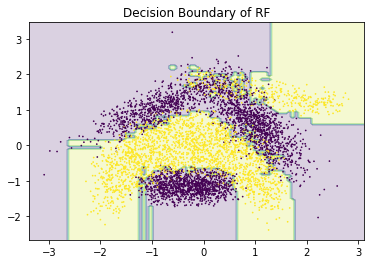

<Figure size 432x288 with 0 Axes>

In [5]:
Z = np.array(tree_preds).mean(axis=0).argmax(axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)
plt.title('Decision Boundary of RF')
plt.savefig('figures/rf.png', bbox_inches='tight', dpi=300)
plt.show()
plt.clf()

##### Boundary of RF with random weighted averaging

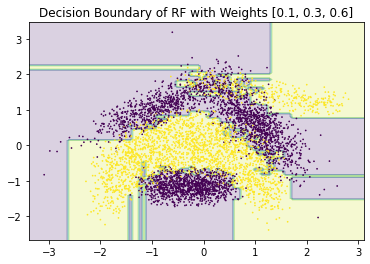

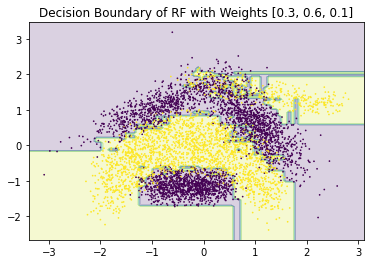

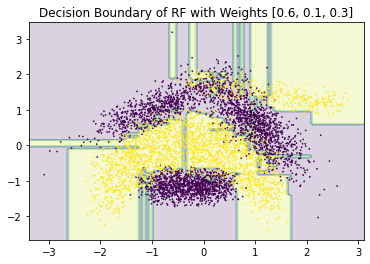

<Figure size 432x288 with 0 Axes>

In [6]:
weights = [[0.1, 0.3, 0.6], [0.3, 0.6, 0.1], [0.6, 0.1, 0.3]]
for w in weights:
    Z = np.average(np.array(tree_preds), axis=0, weights=w).argmax(axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)
    plt.title('Decision Boundary of RF with Weights {}'.format(w))
    plt.savefig('figures/rf_weighted_w{}.png'.format(w), bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()

### Train DNN ensemble on banana dataset

In [7]:
df = pd.read_csv('./data/banana.csv')
X = df.drop('label', axis=1).to_numpy()
y = df['label'].to_numpy()

# Process data
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()
num_classes = len(np.unique(y))
y_tensor = nn.functional.one_hot(y_tensor, num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=7)
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [8]:
# Define the deep neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
models = []
num_models = 3

In [10]:
# Train num_models deep neural networks
for i in range(num_models):
    model = Net()

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    model.train()

    # Train the model for 10 epochs
    for epoch in range(10):
        for x,y in train_loader:
            outputs = model(x)
            loss = criterion(outputs, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    models.append(model)

In [11]:
# Evaluate the ensemble on the test set
accuracies = []
model.eval()
for model in models:
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test.argmax(dim=1)).float().mean()
    accuracies.append(accuracy)

print("Test set accuracy: {:.2f} +/- {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

Test set accuracy: 0.88 +/- 0.01


### Visualize decision boundaries

##### Boundaries of each model

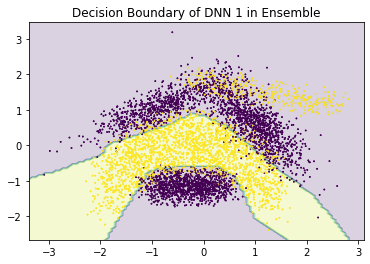

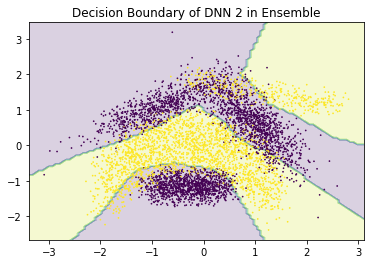

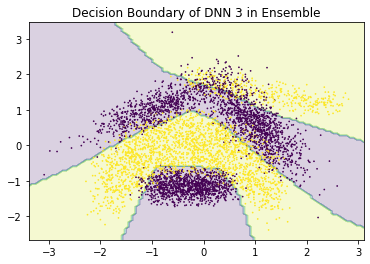

<Figure size 432x288 with 0 Axes>

In [12]:
model.eval()
plt.scatter(X[:, 0], X[:, 1], c=df['label'], s=0.5)

# Create a grid of points over the plot
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Apply the decision function of each model to the grid of points
dnn_preds = []
for i,model in enumerate(models):
    outputs = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float())
    _, Z = torch.max(outputs.data, 1)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=df['label'], s=0.5)
    plt.title('Decision Boundary of DNN {} in Ensemble'.format(i+1))
    plt.savefig('figures/example_dnn{}.png'.format(i+1), bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()

    dnn_preds.append(outputs.data.numpy())

##### Boundary of full DNN ensemble

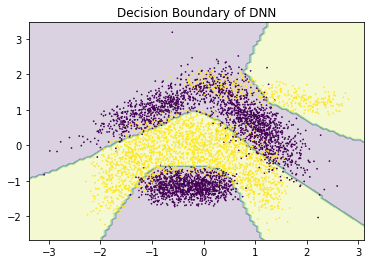

<Figure size 432x288 with 0 Axes>

In [13]:
Z = np.array(dnn_preds).mean(axis=0).argmax(axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=df['label'], s=0.5)
plt.title('Decision Boundary of DNN')
plt.savefig('figures/dnn.png', bbox_inches='tight', dpi=300)
plt.show()
plt.clf()

##### Boundary of DNN ensemble with random weighted averaging 

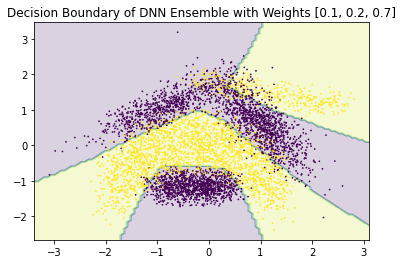

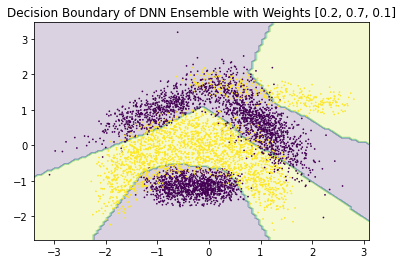

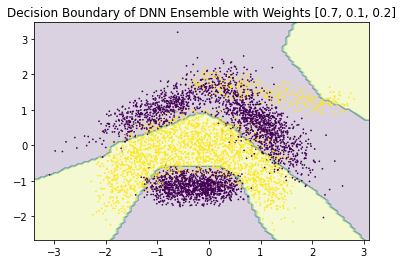

<Figure size 432x288 with 0 Axes>

In [14]:
weights = [[0.1, 0.2, 0.7], [0.2, 0.7, 0.1], [0.7, 0.1, 0.2]]
for w in weights:
    Z = np.average(np.array(dnn_preds), axis=0, weights=w).argmax(axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=df['label'], s=0.5)
    plt.title('Decision Boundary of DNN Ensemble with Weights {}'.format(w))
    plt.savefig('figures/dnn_weighted_w{}.png'.format(w), bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()

### Examine effect of sampling subsets

In [33]:
import numpy as np
from scipy.stats import ks_2samp
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

# load banana dataset
df = pd.read_csv('./data/banana.csv')
X = df.drop('label', axis=1).to_numpy()
y = df['label'].to_numpy()

# split the data into two subsets
subset1 = X[y == 0]
subset2 = X[y == 1]

In [48]:
def ks_test(subset1, subset2):
    # perform K-S test
    for f in range(subset1.shape[1]):
        statistic, pvalue = ks_2samp(subset1[:,f], subset2[:,f])
        print("K-S statistic F{}: {}".format(f+1, statistic))
        print("p-value F{}: {}".format(f+1, pvalue))

In [53]:
def mmd(subset1, subset2):
    # calculate the pairwise distances between each sample in the subsets
    distances1 = pairwise_distances(subset1, metric='euclidean')
    distances2 = pairwise_distances(subset2, metric='euclidean')

    # calculate the mean of the distances in each subset
    mean1 = np.mean(distances1)
    mean2 = np.mean(distances2)

    # calculate the MMD
    mmd = abs(mean1 - mean2)
    print('MMD: ', mmd)

##### Random sample manipulation (oversampling/undersampling random groups)

In [54]:
# Class count
df = pd.read_csv('./data/banana.csv')
count_class_0, count_class_1 = df.label.value_counts()

# Divide by class
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1]

# Random under-sampling
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

# Random over-sampling
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_1_over, df_class_0], axis=0)

subset1 = df_over.drop('label', axis=1).to_numpy()
subset2 = df_under.drop('label', axis=1).to_numpy()

print(subset1.shape, subset2.shape)

mmd(subset1, subset2)
ks_test(subset1, subset2)
# print('')

(5848, 2) (4752, 2)
MMD:  0.0028965106853897638
K-S statistic F1: 0.008155540816279531
p-value F1: 0.994214872475902
K-S statistic F2: 0.007279820549314394
p-value F2: 0.9988730108775136


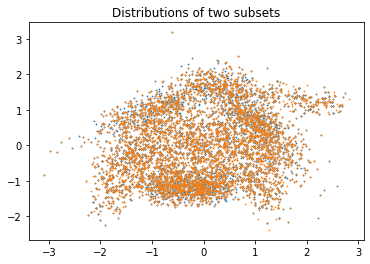

In [46]:
plt.scatter(subset1[:,0], subset1[:,1], s=0.5)
plt.scatter(subset2[:,0], subset2[:,1], s=0.5)
plt.title('Distributions of two subsets')
plt.show()

### Show OOD vs ID queries

In [58]:
from cleanlab.outlier import OutOfDistribution

ood = OutOfDistribution()

# To get outlier scores for train_data using feature matrix train_feature_embeddings
ood_train_feature_scores = ood.fit_score(features=X_train)

# To get outlier scores for additional test_data using feature matrix test_feature_embeddings
ood_test_feature_scores = ood.score(features=X_test)
print(ood_train_feature_scores)
print(ood_test_feature_scores)

Fitting OOD estimator based on provided features ...
[0.9999942  0.9999964  0.99999094 ... 0.9999926  0.99998707 0.9999938 ]
[0.99997205 0.9999884  0.9999892  ... 0.9999901  0.9999906  0.9999961 ]


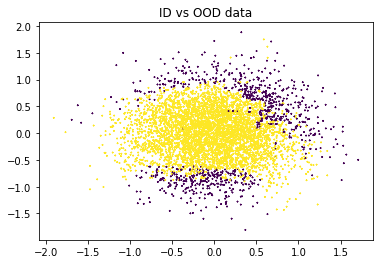

In [101]:
ood_data = np.random.normal(0, 0.5, X.shape)
# ood_data = X + noise
# for i in range(X.shape[0]):
#     ood_data[i,0] = np.random.normal(0,1)

# print(ood.score(features=ood_data))

# plt.scatter(X[:,0], X[:,1], c=df['label'], s=1)
plt.scatter(ood_data[:,0], ood_data[:,1], c=clf.predict(ood_data), s=1, marker='x')
plt.title('ID vs OOD data')
plt.show()